In [5]:
# Imports

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import curve_fit

# plt.rcParams.update({"font.size": 18})
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

import desc.io
from desc.equilibrium.coords import get_rtz_grid
from desc.grid import Grid

# from desc.compute.utils import dot
from desc.backend import jnp
from desc.plotting import plot_surfaces

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DESC version 0.12.2+413.gaeb2ff8f0.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 20.90 GB available memory


In [6]:
eq_fam_w7x = desc.io.load("/home/jjfrybes/DESC/docs/notebooks/tutorials/w7x_output.h5")
eq_w7x = eq_fam_w7x[-1]

In [7]:
# Function to get value of a parameter directly
def get_value(eq, name, grid):
    return eq.compute(name, grid=grid)[name]


def get_arc_length(diff_l, grid):
    # Integrate differential length along field line with respect to zeta
    return cumulative_trapezoid(diff_l, x=grid.source_grid.nodes[:, 2], initial=0)


# Function to get the straight field line coordinate system
def get_field_line_grid(eq, rho=0.5, alpha=0, n_pol=4, n_points=200):
    # Get initial grid to get iota value
    initial_grid = get_rtz_grid(
        eq,
        np.array(np.sqrt(rho)),
        # np.array(rho),
        np.array(alpha),
        np.array(0),
        coordinates="raz",
        period=(np.inf, 2 * np.pi, np.inf),
    )
    iota = np.abs(get_value(eq, "iota", initial_grid)[1])
    NFP = eq.NFP
    n_tor = n_pol / (iota * NFP)
    good_grid = get_rtz_grid(
        eq,
        np.array(np.sqrt(rho)),
        # np.array(rho),
        np.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        np.linspace(0, 2 * n_tor * np.pi, n_points * n_pol),
        coordinates="raz",
        period=(np.inf, 2 * np.pi, np.inf),
    )
    return good_grid

In [26]:
eq = eq_w7x.copy()
grid = get_field_line_grid(eq, n_pol=10)
kappa_g = get_value(eq, "kappa_g", grid)
diff_l = get_value(eq, "|e_zeta|r,a|", grid)
l = get_arc_length(diff_l, grid)
a = get_value(eq, "a", grid)
# l = l/a

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Define the sinusoidal fit function: κG,fit = |A|sin(2πl/LG)
def geodesic_curvature_fit(l, A, L_G):
    return np.abs(A) * np.sin(2 * np.pi * l / L_G)


# Function to compute, fit, and plot geodesic curvature
def fit_and_plot_geodesic_curvature(l, kappa_g):
    # Initial guess for the fit parameters [Amplitude, L_G]
    initial_guess = [np.max(kappa_g), 12]

    # Fit the geodesic curvature to the periodic form
    params, params_covariance = curve_fit(
        geodesic_curvature_fit, l, kappa_g, p0=initial_guess, maxfev=5000
    )

    # Extract fitted parameters
    A_fit, L_G_fit = params

    # Generate the fitted curve
    kappa_g_fit = geodesic_curvature_fit(l, A_fit, L_G_fit)

    # Plotting the original data and the fit
    plt.figure(figsize=(10, 6))
    plt.plot(l, kappa_g, "b-", label="Geodesic Curvature (Data)")
    plt.plot(
        l,
        kappa_g_fit,
        "r--",
        label=f"Fit: |A|sin(2πl/LG)\n|A| = {A_fit:.3f}, LG = {L_G_fit:.3f}",
    )
    plt.xlabel("l (coordinate along field line)")
    plt.ylabel("κG (Geodesic Curvature)")
    plt.title("Geodesic Curvature Fit")
    plt.legend()
    plt.grid(True)
    plt.show()

    return A_fit, L_G_fit

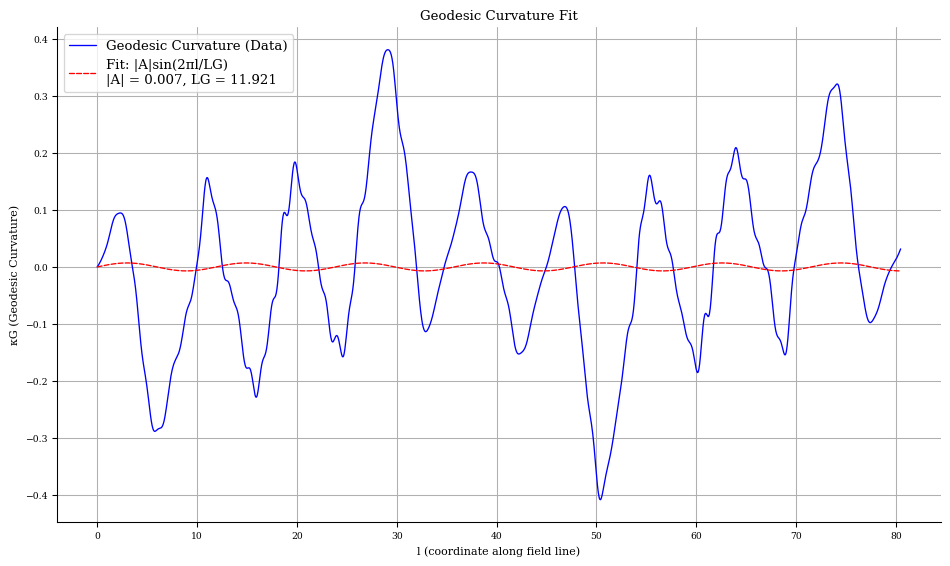

(0.006996448887612924, 11.920714453002521)

In [53]:
fit_and_plot_geodesic_curvature(l, kappa_g)

In [28]:
def find_periodicity(l, kappa_g):
    # Subtract the mean to remove any DC component (offset)
    kappa_g_detrended = kappa_g - np.mean(kappa_g)

    # Perform the FFT
    fft_vals = np.fft.fft(kappa_g_detrended)
    fft_freqs = np.fft.fftfreq(
        len(kappa_g), d=(l[1] - l[0])
    )  # Calculate the frequencies

    # Compute the power spectrum (magnitude of FFT values)
    power_spectrum = np.abs(fft_vals) ** 2

    # Find the index of the peak in the power spectrum (ignoring the zero frequency)
    positive_freqs = fft_freqs > 0  # Only consider positive frequencies
    peak_index = np.argmax(power_spectrum[positive_freqs])

    # Get the corresponding dominant frequency
    dominant_frequency = fft_freqs[positive_freqs][peak_index]

    # The periodicity is the inverse of the dominant frequency
    periodicity = 1 / dominant_frequency

    # Plot the power spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(
        fft_freqs[positive_freqs],
        power_spectrum[positive_freqs],
        "b-",
        label="Power Spectrum",
    )
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.title("Power Spectrum of Geodesic Curvature Signal")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Dominant Frequency: {dominant_frequency}")
    print(f"Estimated Periodicity: {periodicity}")

    return periodicity

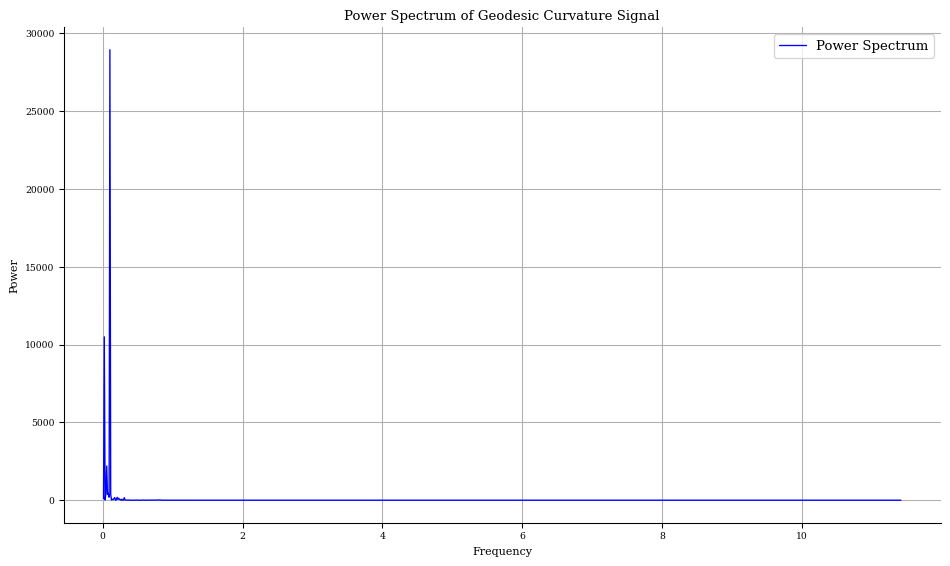

Dominant Frequency: 0.10284889064575099
Estimated Periodicity: 9.723002297072545


9.723002297072545

In [29]:
find_periodicity(l, kappa_g)